In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import re
from matplotlib.ticker import MaxNLocator

LINEWIDTH = 2
FONTSIZE = 12

# 1) Load CSV with two header rows
csv_path = "results.csv"
df = pd.read_csv(csv_path, header=[0, 1])

task_series   = df.iloc[:, 0]
metric_series = df.iloc[:, 1].astype(str).str.strip()
sota_series = pd.to_numeric(df.iloc[:, 1], errors="coerce")
wide_vals   = df.iloc[:, 4:].apply(pd.to_numeric, errors="coerce").dropna(axis=1, how="all")
task_series = df.iloc[:, 0]
sota_by_task = dict(zip(task_series, sota_series))

In [2]:
# 2) Make a per-task metric + arrow map
ARROW_BY_METRIC = {
    # lower is better
    "MAE": "↓", "MSE": "↓", "RMSE": "↓", "MAPE": "↓",
    "L1": "↓", "L2": "↓",
    # higher is better
    "R2": "↑", "R^2": "↑", "R-SQUARED": "↑",
    "ACCURACY": "↑", "ACC": "↑",
    "F1": "↑", "F1-SCORE": "↑",
    "AUROC": "↑", "ROC-AUC": "↑", "AUC": "↑",
    "AUPRC": "↑", "PR-AUC": "↑",
    "MCC": "↑",
    "SPEARMAN": "↑", "SPEARMANR": "↑", "SPEARMANRHO": "↑", "ρ": "↑",
    "PEARSON": "↑", "PCC": "↑",
    "KENDALL": "↑", "TAU": "↑",
}

def metric_to_arrow(name: str) -> str:
    key = re.sub(r'\s+', '', name).upper()
    return ARROW_BY_METRIC.get(key, "↑")  # default to ↑ if unknown

metric_name_by_task = {}
arrow_by_task = {}
for i, task in task_series.items():
    mname = metric_series.iloc[i]
    metric_name_by_task[task] = mname
    arrow_by_task[task] = metric_to_arrow(mname)

long_vals = (
    wide_vals
    .stack([0, 1])  # stack (method, param)
    .reset_index()
)
long_vals.columns = ["task_index", "method", "param", "value"]
long_vals["task"] = task_series.loc[long_vals["task_index"]].values
df_long = long_vals.dropna(subset=["value"]).reset_index(drop=True)

def to_numeric_param(p):
    s = str(p).strip().upper()
    s = s.replace("B", "E9").replace("M", "E6").replace("K", "E3")
    try:
        return float(s)
    except:
        return np.nan

df_long["param_value"] = df_long["param"].apply(to_numeric_param)

/tmp/ipykernel_3160855/2095273440.py:30: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  wide_vals


In [3]:
df_long.head(20)

,task_index,method,param,value,task,param_value
0,0,GCN,0.1M,4.668,Caco2_Wang,100000.0
1,0,GCN,1M,0.601,Caco2_Wang,1000000.0
2,0,GCN,10M,0.501,Caco2_Wang,10000000.0
3,0,GCN (ToyMix),0.1M,5.293,Caco2_Wang,100000.0
4,0,GCN (ToyMix),1M,2.277,Caco2_Wang,1000000.0
5,0,GCN (ToyMix),10M,0.539,Caco2_Wang,10000000.0
6,0,MPNN+ (ToyMix),1M,3.872,Caco2_Wang,1000000.0
7,0,MPNN+ (ToyMix),10M,4.782,Caco2_Wang,10000000.0
8,0,MPNN+ (ToyMix),100M,2.275,Caco2_Wang,100000000.0
9,1,GCN,0.1M,0.716,HIA_Hou,100000.0


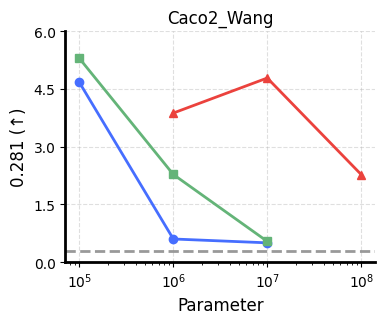

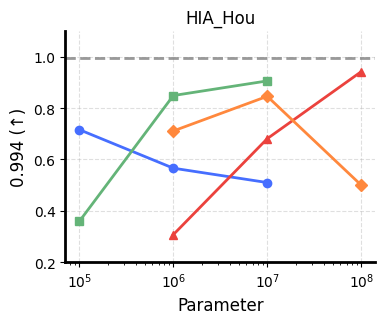

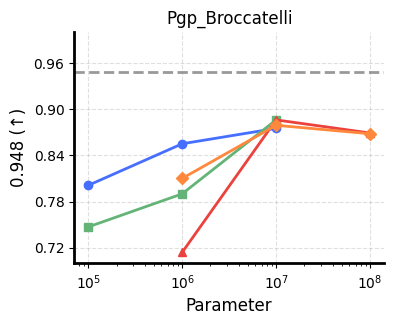

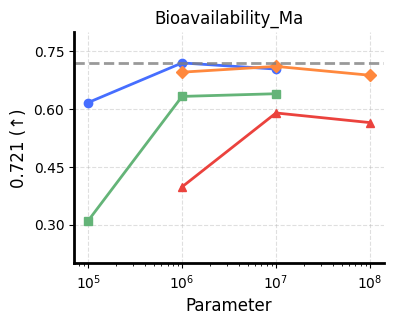

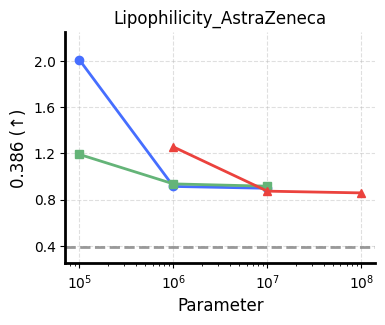

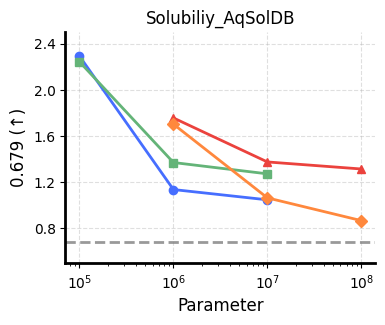

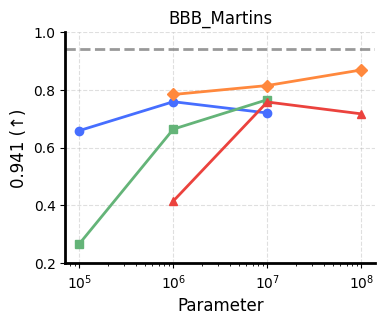

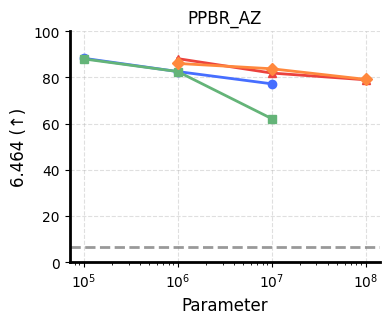

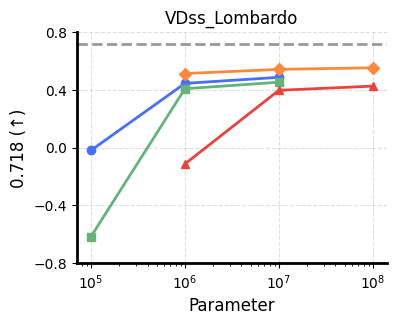

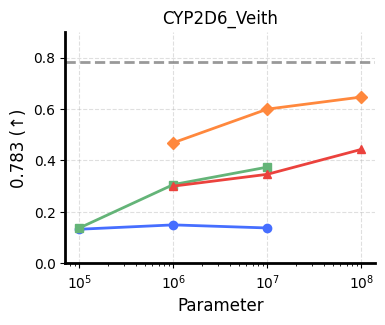

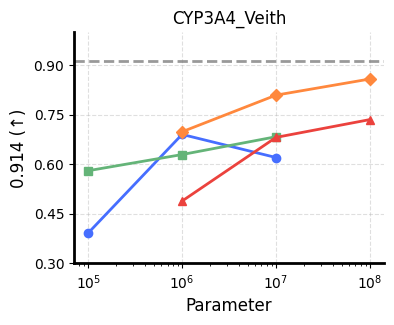

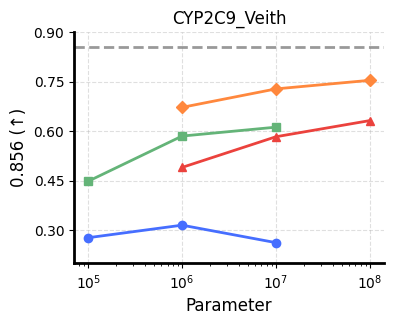

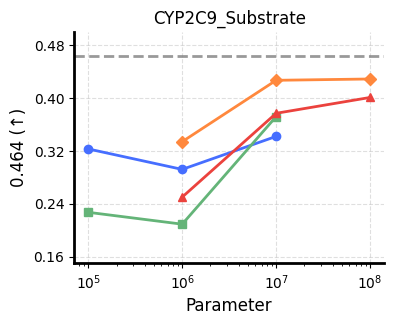

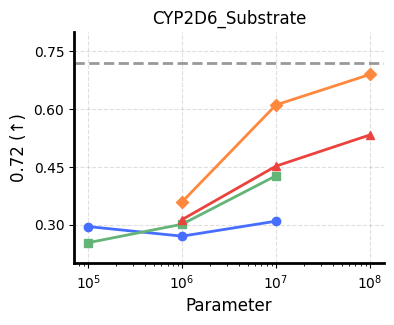

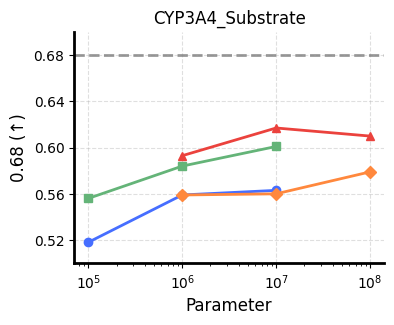

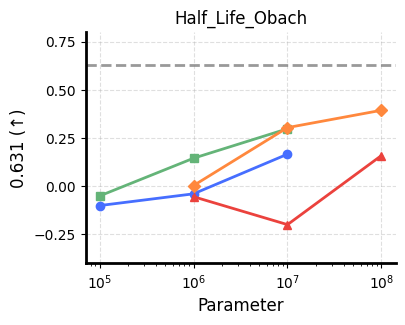

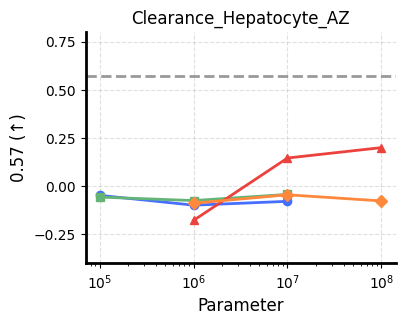

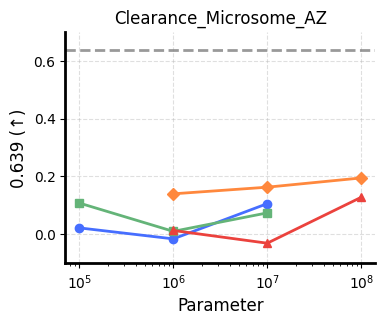

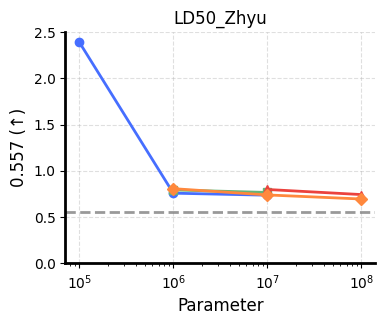

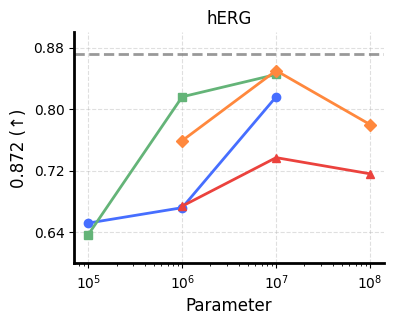

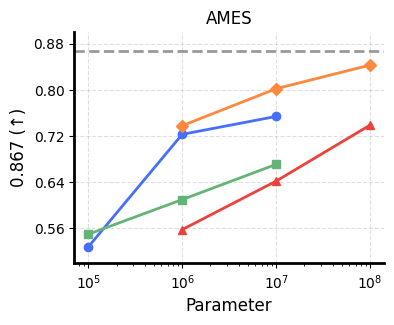

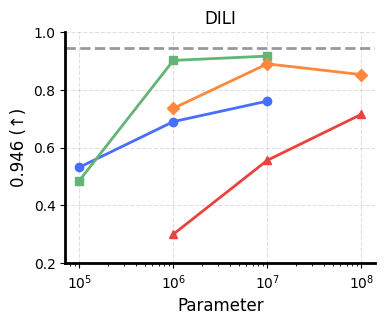

In [4]:
# 4) Plot per task
methods = df_long["method"].dropna().unique()
blue = "#466eff"
green = "#64B478"
red = "#EB423D"
orange = "#FF883D"
colors = cycle([blue, green, red, orange])
markers = cycle(["o", "s", "^", "D", "P", "X", "v", "*"])
style   = {m: (next(colors), next(markers)) for m in methods}

for task in df_long["task"].unique():
	dtask = df_long[df_long["task"] == task].copy()
	if dtask.empty:
		continue

	fig, ax = plt.subplots(figsize=(4, 3))
	for m in methods:
		dm = dtask[dtask["method"] == m].sort_values("param_value")
		if dm.empty:
			continue
		color, marker = style[m]
		ax.plot(
			dm["param_value"], dm["value"],
			marker=marker, linestyle="-", color=color, label=m,
			linewidth=2, 
   			# s=np.log10(dm["param_value"] - 4) ** 4, alpha=0.7
		)

 
	sota = sota_by_task.get(task, np.nan)
	if pd.notna(sota):
		ax.axhline(y=sota, color="gray", linewidth=2.0, alpha=0.8, label="SOTA", linestyle="--")
		ymin, ymax = ax.get_ylim()
		offset = 0.02 * (ymax - ymin)  # vertical offset
		text_y = sota + offset if arrow_by_task[task] == "↑" else sota - offset
		current_ticks = list(ax.get_yticks())
		current_ticks.append(sota)
		ax.set_yticks(sorted(current_ticks))
	ax.spines['top'].set_visible(False)
	ax.spines['right'].set_visible(False)
	ax.spines['left'].set_linewidth(LINEWIDTH)
	ax.spines['bottom'].set_linewidth(LINEWIDTH)
	ax.tick_params(axis='both')
	ax.set_xticks([])
	# ax.set_yticks([])
	ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
	ax.set_axisbelow(True)
	ax.set_xscale("log")
	ax.set_title(task)
	fig.align_ylabels(ax)	
	ax.set_xlabel("Parameter", fontsize=FONTSIZE)
	y_metric = metric_name_by_task.get(task, "Performance")
	y_arrow  = arrow_by_task.get(task, "↑")
	ax.set_ylabel(f"{y_metric} ({y_arrow})", fontsize=FONTSIZE)
	ax.grid(True, ls="--", alpha=0.4)
	# ax.legend()
	# ax.legend(loc='lower center', bbox_to_anchor=(0.5, 2), ncol=2)
	plt.show()

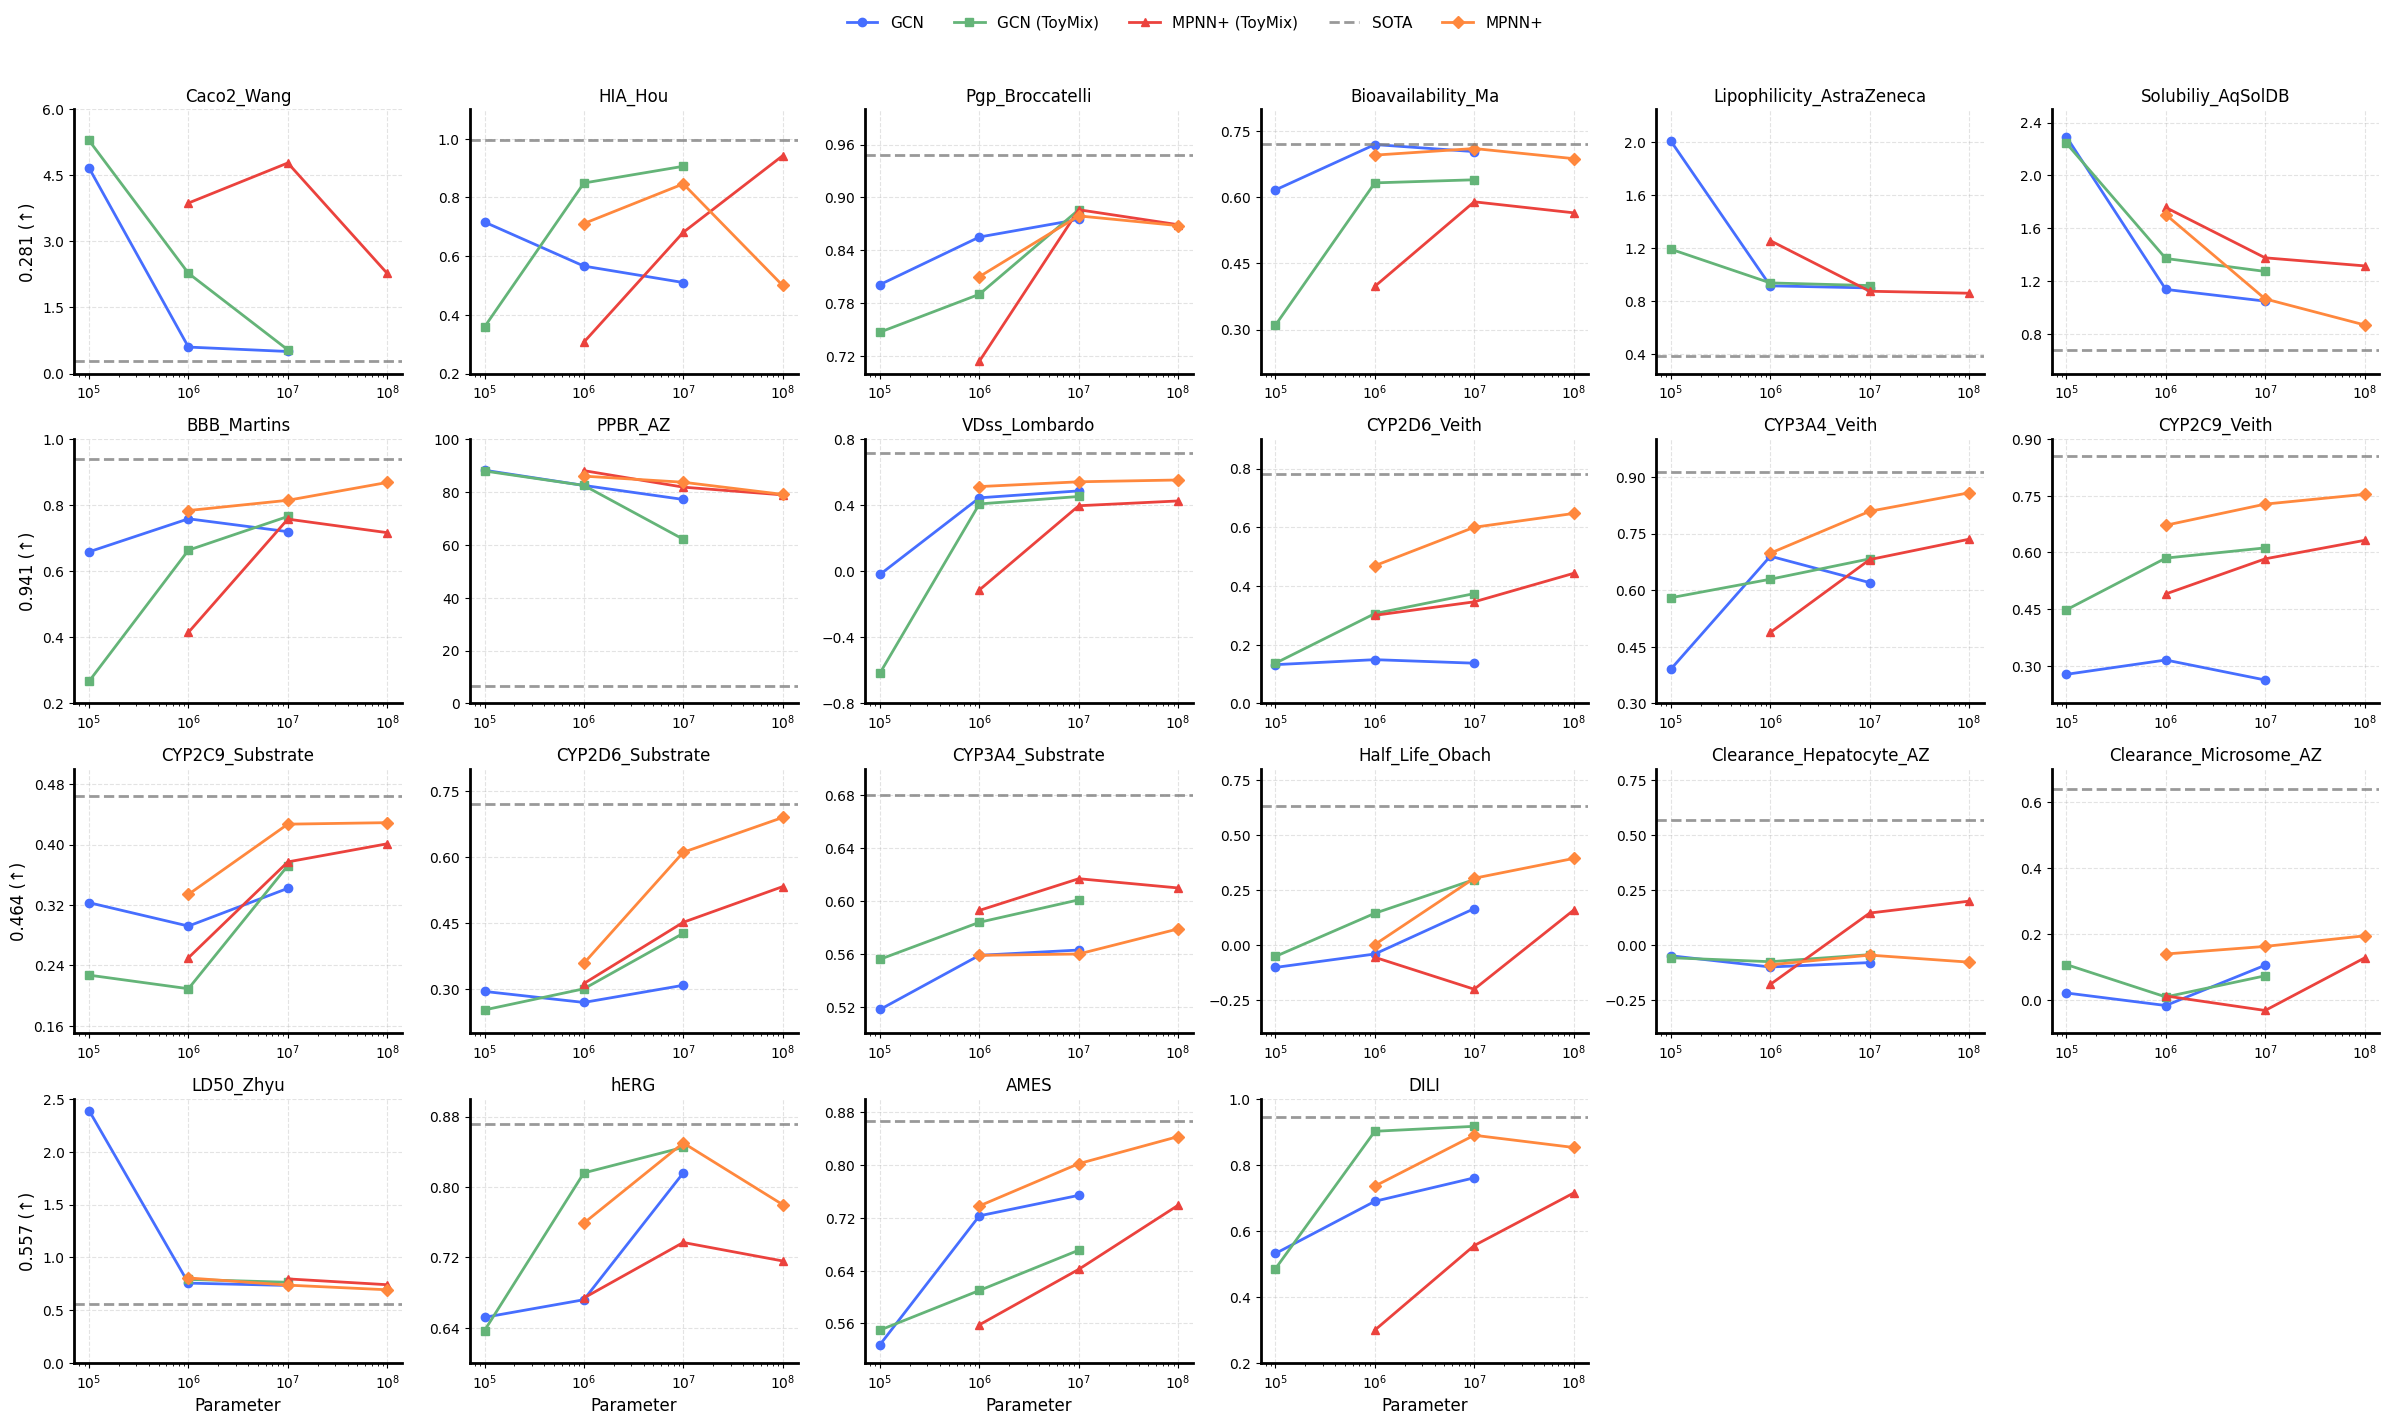

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

def plot_tasks_grid(
    df_long,
    sota_by_task,
    metric_name_by_task,
    arrow_by_task,
    nrows=4,
    ncols=6,
    methods=None,
    FONTSIZE=12,
    LINEWIDTH=1.8,
):
    # ---- styling (reuse your palette/markers) ----
    blue = "#466eff"
    green = "#64B478"
    red = "#EB423D"
    orange = "#FF883D"
    _methods = df_long["method"].dropna().unique() if methods is None else methods
    colors = cycle([blue, green, red, orange])
    markers = cycle(["o", "s", "^", "D", "P", "X", "v", "*"])
    style = {m: (next(colors), next(markers)) for m in _methods}

    tasks = list(df_long["task"].unique())
    total = nrows * ncols
    # pad with None so we fill the grid cleanly
    tasks = tasks + [None] * (total - len(tasks)) if len(tasks) < total else tasks[:total]

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3.5), sharex=False, sharey=False)
    axes = np.array(axes).reshape(nrows, ncols)

    # for a single collected legend
    legend_handles_labels = None

    for idx, task in enumerate(tasks):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]

        if task is None:
            ax.axis("off")
            continue

        dtask = df_long[df_long["task"] == task]
        if dtask.empty:
            ax.axis("off")
            continue

        # plot each method line + points
        for m in _methods:
            dm = dtask[dtask["method"] == m].sort_values("param_value")
            if dm.empty:
                continue
            color, marker = style[m]
            h = ax.plot(
                dm["param_value"], dm["value"],
                marker=marker, linestyle="-", color=color, label=m,
                linewidth=2
            )
            # capture handles for a shared legend
            if legend_handles_labels is None:
                legend_handles_labels = ax.get_legend_handles_labels()

        # SOTA line + y-tick
        sota = sota_by_task.get(task, np.nan)
        if hasattr(np, "isnan") and not np.isnan(sota):
            ax.axhline(y=sota, color="gray", linewidth=2.0, alpha=0.8,
                       label="SOTA", linestyle="--")
            ticks = list(ax.get_yticks()) + [sota]
            ax.set_yticks(sorted(ticks))

        # cosmetics
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(LINEWIDTH)
        ax.spines['bottom'].set_linewidth(LINEWIDTH)
        ax.tick_params(axis='both')
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_xscale("log")
        ax.grid(True, ls="--", alpha=0.35)
        ax.set_title(task, fontsize=FONTSIZE)

        # y label only on leftmost column
        if c == 0:
            y_metric = metric_name_by_task.get(task, "Performance")
            y_arrow  = arrow_by_task.get(task, "↑")
            ax.set_ylabel(f"{y_metric} ({y_arrow})", fontsize=FONTSIZE)
        # x label only on bottom row
        if r == nrows - 1:
            ax.set_xlabel("Parameter", fontsize=FONTSIZE)
        else:
            # keep x-ticks but smaller or hide if you prefer
            pass

    # global legend (top-right outside)
    if legend_handles_labels is not None:
        handles, labels = legend_handles_labels
        # Add SOTA handle if any subplot drew it and it's not already in handles
        handles2, labels2 = [], []
        for ax in axes.flat:
            h2, l2 = ax.get_legend_handles_labels()
            for h, l in zip(h2, l2):
                if l not in labels2:
                    handles2.append(h); labels2.append(l)
        fig.legend(handles2, labels2, loc="upper center", ncol=min(len(labels2), 6),
                   bbox_to_anchor=(0.5, 1.02), frameon=False, fontsize=FONTSIZE-1)

    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
plot_tasks_grid(
    df_long=df_long,
    sota_by_task=sota_by_task,
    metric_name_by_task=metric_name_by_task,
    arrow_by_task=arrow_by_task,
    nrows=4,
    ncols=6,
    FONTSIZE=FONTSIZE,
    LINEWIDTH=LINEWIDTH,
)